In [1]:
import pandas as pd
import tensorflow_hub as hub
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import plotly.graph_objects as go
from kneed import KneeLocator
import plotly.io as pio
import os

# Set the working directory to the previous directory
os.chdir('..')

2024-06-01 12:41:12.820101: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 12:41:12.822553: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 12:41:12.826684: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 12:41:12.871082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 12:41:14.561382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
df = pd.read_csv("./data/lyrics_proc_train.csv")
print('Data rows number: ', len(df))
df.head()

Data rows number:  4736


,id,artist,title,lyrics,lyrics_proc
0,7828,Bon Jovi,Let It Rock,\n\r\nThe weekend comes to this town \r\nSeven...,weekend come town seven soon make break rule w...
1,2706,Eminem,Music Box,"\n\r\nYeah, girl.\nCan you hear that?\nIt's pl...",girl hear play song sleepi take afraid dark he...
2,4658,Johnny Cash,Redemption Day,\n\r\nI've wept for those who suffer long\r\nB...,wept suffer long weep gone room grief question...
3,14321,Beyonce,Party (Homecoming Live),"\n\r\nI may be young, but I'm ready\nTo give y...",young readi give love told girl slow love give...
4,4352,Johnny Cash,I Came To Believe,\n\r\nI couldn't manage the problems I laid on...,could manag problem laid made wors laid somebo...


### Load USE with TF

In [3]:
# Load the Universal Sentence Encoder module (transformer-based variant)
use = hub.load('./models/use')

lyrics_embeddings = df['lyrics_proc'].apply(lambda lyrics: use([lyrics]).numpy()[0])
lyrics_embeddings

2024-06-01 12:41:40.831946: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-01 12:41:54.817577: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


0       [0.021139791, 0.047813307, -0.05514289, 0.0430...
1       [-0.098095804, 0.051229965, -0.009584355, 0.03...
2       [-0.07834105, -0.0009774409, 0.022217747, -0.0...
3       [-0.005090266, -0.031644553, -0.09804028, 0.02...
4       [-0.012233378, 0.03183596, -0.04661106, -0.030...
                              ...                        
4731    [-0.047154695, 0.045356654, -0.09630356, 0.028...
4732    [-0.0627335, -0.043271363, -0.052010898, 0.017...
4733    [0.02069832, -0.021812424, -0.056579098, 0.001...
4734    [-0.009164859, -0.018467782, -0.067718856, 0.0...
4735    [0.014911008, -0.026014958, -0.08406429, -0.02...
Name: lyrics_proc, Length: 4736, dtype: object

In [13]:
df['use_embeddings'] = lyrics_embeddings
df.head()

,id,artist,title,lyrics,lyrics_proc,use_embeddings
0,7828,Bon Jovi,Let It Rock,\n\r\nThe weekend comes to this town \r\nSeven...,weekend come town seven soon make break rule w...,"[0.021139791, 0.047813307, -0.05514289, 0.0430..."
1,2706,Eminem,Music Box,"\n\r\nYeah, girl.\nCan you hear that?\nIt's pl...",girl hear play song sleepi take afraid dark he...,"[-0.098095804, 0.051229965, -0.009584355, 0.03..."
2,4658,Johnny Cash,Redemption Day,\n\r\nI've wept for those who suffer long\r\nB...,wept suffer long weep gone room grief question...,"[-0.07834105, -0.0009774409, 0.022217747, -0.0..."
3,14321,Beyonce,Party (Homecoming Live),"\n\r\nI may be young, but I'm ready\nTo give y...",young readi give love told girl slow love give...,"[-0.005090266, -0.031644553, -0.09804028, 0.02..."
4,4352,Johnny Cash,I Came To Believe,\n\r\nI couldn't manage the problems I laid on...,could manag problem laid made wors laid somebo...,"[-0.012233378, 0.03183596, -0.04661106, -0.030..."


In [14]:
def find_optimal_pca_dimensions(df, embeddings_column, dimensions, n_clusters=5):
    
    # Extract the embeddings from the DataFrame
    embeddings = np.stack(df[embeddings_column].values)
    
    # Apply Standard Scaler
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    results = []
    for dim in dimensions: 
        # Apply PCA
        pca = PCA(n_components=dim)
        reduced_embeddings = pca.fit_transform(scaled_embeddings)

        # Cluster the reduced embeddings
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_embeddings)

        # Compute the Silhouette score
        silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)

        # Calculate variance preserved
        variance_preserved = np.sum(pca.explained_variance_ratio_)

        # Append results
        results.append({
            'Dimensions': dim,
            'Silhouette Score': silhouette_avg,
            'Variance Preserved': variance_preserved
        })

    return pd.DataFrame(results)

dimensions = [2,3,5,10,15,20,35,50]

table = find_optimal_pca_dimensions(df,'use_embeddings',dimensions)
table

,Dimensions,Silhouette Score,Variance Preserved
0,2,0.372719,0.119539
1,3,0.308380,0.146788
2,5,0.238842,0.191301
3,10,0.145636,0.271741
4,15,0.115821,0.326364
5,20,0.105606,0.370987
6,35,0.076397,0.471055
7,50,0.080041,0.544859


In [15]:
def find_best_tradeoff(results_df):
    
    # Calculate the absolute difference between the normalized metrics
    results_df['Difference'] = np.abs(results_df['Silhouette Score'] - results_df['Variance Preserved'])
    
    # Find the dimension with the minimum difference
    best_dimension = results_df.loc[results_df['Difference'].idxmin(), 'Dimensions']
    
    return best_dimension, results_df

best_dim, _ = find_best_tradeoff(table)
print("The best dimension is: ", best_dim)

# Extract the embeddings from the DataFrame
embeddings = np.stack(df['use_embeddings'].values)

# Apply Standard Scaler
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Apply PCA
pca = PCA(n_components=best_dim)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Add reduced embedding as new column
df['reduced_embeddings'] = reduced_embeddings.tolist()
df.head()

The best dimension is:  5


,id,artist,title,lyrics,lyrics_proc,use_embeddings,reduced_embeddings
0,7828,Bon Jovi,Let It Rock,\n\r\nThe weekend comes to this town \r\nSeven...,weekend come town seven soon make break rule w...,"[0.021139791, 0.047813307, -0.05514289, 0.0430...","[-0.6139145493507385, -2.064741611480713, -9.1..."
1,2706,Eminem,Music Box,"\n\r\nYeah, girl.\nCan you hear that?\nIt's pl...",girl hear play song sleepi take afraid dark he...,"[-0.098095804, 0.051229965, -0.009584355, 0.03...","[10.772502899169922, -5.588329315185547, 6.276..."
2,4658,Johnny Cash,Redemption Day,\n\r\nI've wept for those who suffer long\r\nB...,wept suffer long weep gone room grief question...,"[-0.07834105, -0.0009774409, 0.022217747, -0.0...","[-1.1664633750915527, -2.7152841091156006, 4.2..."
3,14321,Beyonce,Party (Homecoming Live),"\n\r\nI may be young, but I'm ready\nTo give y...",young readi give love told girl slow love give...,"[-0.005090266, -0.031644553, -0.09804028, 0.02...","[-2.7755374908447266, 1.846039056777954, -1.57..."
4,4352,Johnny Cash,I Came To Believe,\n\r\nI couldn't manage the problems I laid on...,could manag problem laid made wors laid somebo...,"[-0.012233378, 0.03183596, -0.04661106, -0.030...","[-1.86981999874115, -0.9391576051712036, -0.80..."


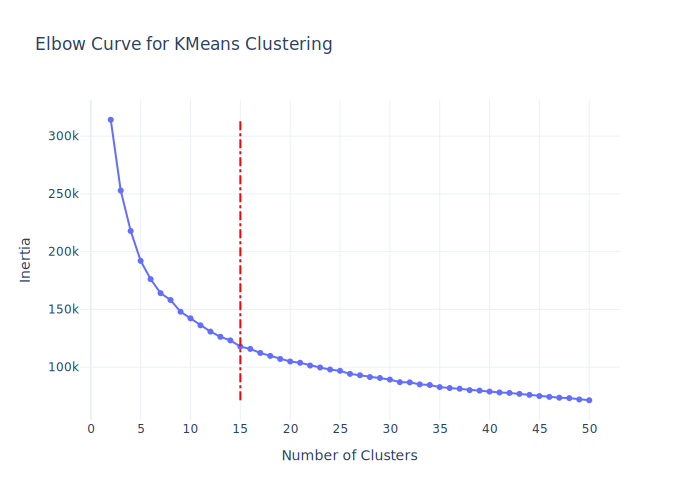

The best number of clusters is:  15


In [17]:
def plot_elbow_curve(df, cluster_range=(2, 50)):
    # Extract the embeddings from the DataFrame
    reduced_embeddings = np.stack(df['reduced_embeddings'].values)

    # Initialize variables to store inertia values
    cluster_range_values = range(cluster_range[0], cluster_range[1] + 1)
    inertia_values = []

    # Compute inertia for each number of clusters
    for n_clusters in cluster_range_values:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(reduced_embeddings)
        inertia_values.append(kmeans.inertia_)
    
    # Use the KneeLocator to find the elbow point
    knee = KneeLocator(cluster_range_values, inertia_values, curve='convex', direction='decreasing')

    # Plot the elbow curve using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(cluster_range_values)[::1],
        y=inertia_values,
        mode='lines+markers',
        name='Inertia'
    ))

    fig.add_shape(
        type="line",
        x0=knee.elbow,
        y0=min(inertia_values),
        x1=knee.elbow,
        y1=max(inertia_values),
        line=dict(
            color="red",
            width=2,
            dash="dashdot",
        ),
    )

    fig.update_layout(
        title='Elbow Curve for KMeans Clustering',
        xaxis_title='Number of Clusters',
        yaxis_title='Inertia',
        xaxis=dict(tickmode='linear', dtick=5),
        template='plotly_white'
    )
    
    # Save plot
    pio.write_image(fig, './plots/use_elbow.pdf')
    # Show the plot
    fig.show("svg")
    return knee.elbow
    
n_clusters = plot_elbow_curve(df)
print("The best number of clusters is: ", n_clusters)

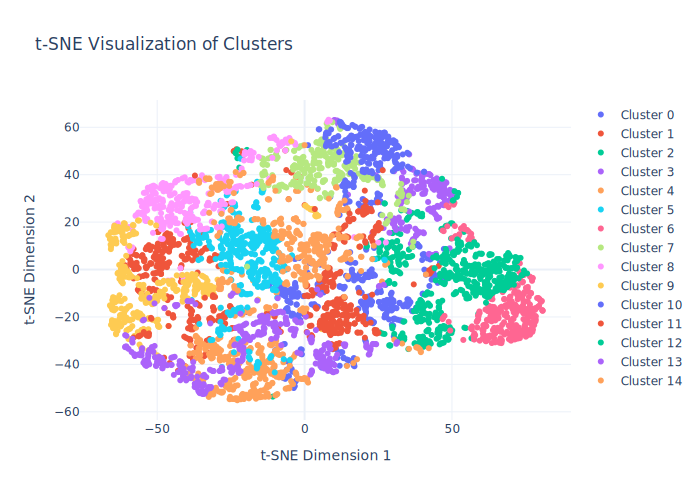

In [18]:
def perform_clustering_and_visualize(df,n_clusters):
    # Extract the embeddings from the DataFrame
    reduced_embeddings = np.stack(df['reduced_embeddings'].values)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_embeddings)

    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(reduced_embeddings)

    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_embeddings, columns=['x', 'y'])
    tsne_df['cluster'] = cluster_labels

    # Create a plotly scatter plot
    fig = go.Figure()

    # Add traces for each cluster
    for cluster in range(n_clusters):
        cluster_df = tsne_df[tsne_df['cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df['x'], y=cluster_df['y'],
            mode='markers',
            name=f'Cluster {cluster}',
            marker=dict(size=6),
            #text=cluster_df.index
        ))

    # Update layout
    fig.update_layout(
        title='t-SNE Visualization of Clusters',
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        template='plotly_white',
        showlegend=True
    )
    
    # Save plot
    pio.write_image(fig, './plots/use_tsne.pdf')
    # Show plot
    fig.show("svg")

    return cluster_labels

cluster_labels = perform_clustering_and_visualize(df, n_clusters)
# Add cluster labels to the lyrics embeddings
df['cluster'] = cluster_labels

In [19]:
def top_n_similar_embeddings(df, target_index, n=10):
    
    # Extract the target embedding and its cluster
    target_embedding = df.at[target_index, 'reduced_embeddings']
    target_cluster = df.at[target_index, 'cluster']
    
    # Filter the DataFrame to get only the embeddings in the same cluster
    cluster_df = df[df['cluster'] == target_cluster]
    cluster_embeddings = np.stack(cluster_df['reduced_embeddings'].values)

    # Calculate cosine similarities
    similarities = cosine_similarity([target_embedding], cluster_embeddings)[0]

    # Get the top n similar embeddings
    top_n_indices = np.argsort(similarities)[-n-1:][::-1]
    top_n_similar_ids = cluster_df.iloc[top_n_indices]['id'].values
    top_n_similarities = similarities[top_n_indices]

    return pd.DataFrame({
        'id': top_n_similar_ids, 
        'similarity': top_n_similarities
    })

# Show top 10 similar song to the first song (the first row is the song itself)
top_n_similar_embeddings(df,target_index=0,n=10)

,id,similarity
0,7828,1.000000
1,19600,0.987727
2,10406,0.983255
3,5494,0.978755
4,288,0.975403
5,19796,0.974747
6,2075,0.972872
7,5136,0.970770
8,24608,0.968703
9,19598,0.964447
